In [1]:
# There are two ways to build keras model, one is sequential
# and other is functional. 
# sequential API allows to build the model layer by layer
from keras.models import Sequential

# Since layers are connected, thus we use Dense class
from keras.layers import Dense

# Dropout is the technique where nuerons are randomly
# not considered during the forward propogation and no weights
# are included for those nuerons during back propogation.
# The dropout occurs during training the model.
# Thus during training, the neighbouring nuerons 
# have to take place of the dropped nuerons
# and help in making predictions. 
# The result of dropout is that the network performs
# well for generalizing predictions. 
# Dropout is not used for testing.
from keras.layers import Dropout

# The constraints is the setting to limit the network 
# parameters(weight and biases),
# these constraints are applied per layer but are enforced 
# on each nueron during the training phase. 
from keras.constraints import maxnorm

# In case of any interruption during the training phase, 
# checkpoint is used to store model weights under certain 
# conditions.
# checkpoint also allows to store accuracy and loss of validation(testing) 
# or training model.
# ModelCheckpoint after above all settings can be passed into model.fit()
from keras.callbacks import ModelCheckpoint

# Keras will store the structure of model to .json file
# when we use to_json() function, the model will be loaded 
# back again from the point it was interrupted when 
# model_from_json() function is used.
from keras.models import model_from_json

# gradient descent optimizer 
from keras import optimizers

import numpy as np

# metrics for viewing loss and accuracy
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

Using TensorFlow backend.


### We can save weights by using checkpoints of keras based on certain condition or by using model.save_weights() function.
#### here we are using checkpoints

In [2]:
# 768 observation and 9 variables
dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
dataset.shape

(768, 9)

In [3]:
# Features(first 8 variables) and Targets(last variables) are assigned 
# to X and Y.
X = dataset[:,0:8]
Y = dataset[:,8] 

In [4]:
# np.random.seed(7) will produce the same set of network weights 
np.random.seed(7)

# building keras model using sequential API - layers
model = Sequential()

# we add a new Dropout layer between the input (or visible layer) 
# and the first hidden layer. The drop out rate is choosed as 10%. 
# "X" has 8 variables and so input_shape() is (8,)
# input_shape=(number_of_features,)
# note: here for dropout we use input_shape() instead of input_dim()
model.add(Dropout(0.1,input_shape=(8,)))

# adding 1st hidden layer which has 10 nuerons.
# activation function "relu" is used.
# relu function: y=max(0,x), returns the maximum
# The addition of product of inputs and the random weights of all the layers
# below will passed through the respective activation function.
# normal distribution will be used to initialise weights, 
# thus, "kernel_initializer='normal'"
# By adding "kernel_constraint=maxnorm(3)" weights are restricted to be below or equal to 3
model.add(Dense(10,  kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(3)))

# adding 2nd hidden/output layer which has 8 neurons
model.add(Dense(8,  kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(3)))

# adding 3rd hidden/output layer which has 1 neuron, the activation
# function used here is "sigmoid" which predicts the targets, ie. "Y"
# values between 1 and 0(probability). 
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

# after adding all the layers to the model, compiling them together with
# additional properties such as gradient descent optimizer called "adam",
# loss: "binary_crossentropy" the predicted observations 
# from the sigmoid activation function will be used to compute 
# loss = -{(y\log(p) + (1 - y)\log(1 - p))}, where log is the natural log, 
# y is binary indicator (0 or 1) and p is predicted probability. Further 
# the weights will be reduced by optimizer till the loss is low or until
# the specified epochs are completed and below 3. Metric allows to monitor 
# the model while training. accuracy value and loss is generated for each epoch 
# in verbose output.
# compiling the model involves Tensorflow at backend using which the weights are
# evaluated and the predictions are made.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Saving the model structure in variable "model_json".
# creating a new file "model_checkpoint.json" in working directory and 
# giving writing permission. 
model_json = model.to_json()
with open('model_checkpoint', 'w') as json_file:
    json_file.write(model_json)
print("")
print('===================')
print('Saved model to disk')
print('===================')

# ModelCheckpoint() will save weights generated during testing the model 
# into the file "weights.best.hdh5" and by using monitor='val_acc' only 
# weights which results improvement in model accuracy are stored. 
# verbose=1 will show you an animated progress bar
# verbose=2 shows epochs
# verbose=0 nothing
filepath = 'weights.best.hdh5'
checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose=0,save_best_only=True,mode='max')
callbacks_list = [checkpoint]

# The model created above will be now trained with data using fit() function.
# For every epoch the loss will be decreased to its minimum.
# verbose = 0 turns off the output progress bars during training
# Validation_split() will split the "X" and "Y" dataset together, by 90%
# into training data set and the remaining 10% into validation data set. 
# if enabled, verbose output on each epoch shows the loss and accuracy on both the 
# training dataset and the validation dataset for every epoch.
# 'callbacks_list' of the callbacks will be called at each stage of the training and
# accordingly weights will be stored in the "weights.best.hdh5" file. 
history=model.fit(X,Y,validation_split=0.1,epochs=1000,verbose=0,callbacks=callbacks_list)

# evaluate() is for evaluating the already trained model using 
# the validation data.
# Returns the loss value and metrics value (accuracy) of the model
# for training/validation data.
scores = model.evaluate(X, Y)

# predict() generates output predictions for the input samples.
Y_predict = model.predict(X)

# model.metrics_names[0:2] has first element "loss" and 2nd "accuracy"
# where as scores 2nd element is loss and we are printing the same.
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

# since the "Y_predicted" values are in between 1 and 0
# because of sigmoid activation
# rounding the prediction values will classify the values
# in 1 and 0's. 
rounded = [round(i[0]) for i in Y_predict]
y_pred = np.array(rounded,dtype='int64')

#confusion matrix is used to evaluate the quality of the output of the model.
#The diagonal elements represent the number of points for which the predicted 
#label is equal to the true label, while off-diagonal elements are those that 
#are mislabeled by the model.
print("")
print('Confusion Matrix')
print('================')
CM = confusion_matrix(Y, y_pred)
print('True negatives: ',CM[0,0])
print('False negatives: ',CM[1,0])
print('False positives: ',CM[0,1])
print('True positives: ',CM[1,1])


Saved model to disk
768/768 [==============================] - 0s 36us/step

acc: 79.82%

loss: 44.13%

Confusion Matrix
True negatives:  468
False negatives:  123
False positives:  32
True positives:  145


In [20]:
# on setting verbose=1 in checkpoint, we will get notified 
# of the saving the best weights which improves the accuracy 
# of the model asfollows:

Epoch 00001: val_acc improved from -inf to 0.59740, saving model to weights.best.hdh5

Epoch 00007: val_acc improved from 0.59740 to 0.61039, saving model to weights.best.hdh5

Epoch 00024: val_acc improved from 0.61039 to 0.64935, saving model to weights.best.hdh5

.

.

.

Epoch 00188: val_acc improved from 0.80519 to 0.80519, saving model to weights.best.hdh5

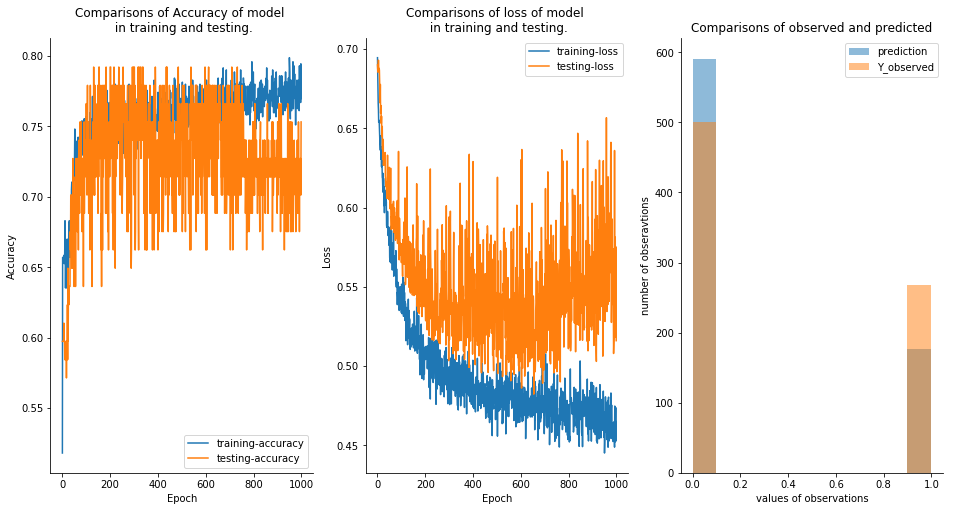

In [8]:
accuracy_training = history.history['acc']
loss_training = history.history['loss']
accuracy_testing = history.history['val_acc']
loss_testing = history.history['val_loss']

ax = plt.subplot(1,3,1)
ax.plot(accuracy_training,label='training-accuracy')
ax.plot(accuracy_testing,label='testing-accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Comparisons of Accuracy of model \n in training and testing.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = plt.subplot(1,3,2)
ax.plot(loss_training,label='training-loss')
ax.plot(loss_testing,label='testing-loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparisons of loss of model \n in training and testing.")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = plt.subplot(1,3,3)
plt.hist(y_pred,alpha=0.5,histtype='stepfilled',label="prediction")
plt.hist(Y,alpha=0.5,histtype='stepfilled', label="Y_observed")
plt.xlabel("values of observations")
plt.ylabel("number of obseravtions")
plt.legend()
plt.title("Comparisons of observed and predicted")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()
plt.rcParams['figure.figsize'] = [16,8]

In [10]:
def nueral_network(dropout, validation_ratio):
    dataset = np.loadtxt("pima-indians-diabetes.csv", delimiter=",")
    X = dataset[:,0:8]
    Y = dataset[:,8] 
    np.random.seed(7)
    model = Sequential()
    model.add(Dropout(dropout,input_shape=(8,))) 
    model.add(Dense(10,  kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(3))) 
    model.add(Dense(8,  kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    model_json = model.to_json()
    with open('model_checkpoint', 'w') as json_file:
        json_file.write(model_json)
    print("")
    print('===================')
    print('Saved model to disk')
    print('===================')
    filepath = 'weights.best.hdh5'
    checkpoint = ModelCheckpoint(filepath,monitor='val_acc',verbose=0,save_best_only=True,mode='max')
    callbacks_list = [checkpoint]
    history=model.fit(X,Y,validation_split=validation_ratio,epochs=1000,verbose=0,callbacks=callbacks_list)
    scores = model.evaluate(X, Y)
    Y_predict = model.predict(X)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)) 
    print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
    print("")
    rounded = [round(i[0]) for i in Y_predict]
    y_pred = np.array(rounded,dtype='int64')
    print("")
    print('Confusion Matrix')
    print('================')
    CM = confusion_matrix(Y, y_pred)
    print('True negatives: ',CM[0,0])
    print('False negatives: ',CM[1,0])
    print('False positives: ',CM[0,1])
    print('True positives: ',CM[1,1])
    print("")
    
    accuracy_training = history.history['acc']
    loss_training = history.history['loss']
    accuracy_testing = history.history['val_acc']
    loss_testing = history.history['val_loss']
    print("============================================================================")
    print("")
    ax = plt.subplot(1,3,1)
    ax.plot(accuracy_training,label='training-accuracy')
    ax.plot(accuracy_testing,label='testing-accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Comparisons of Accuracy of model \n in training and testing.")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax = plt.subplot(1,3,2)
    ax.plot(loss_training,label='training-loss')
    ax.plot(loss_testing,label='testing-loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Comparisons of loss of model \n in training and testing.")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax = plt.subplot(1,3,3)
    plt.hist(y_pred,alpha=0.5,histtype='stepfilled',label="prediction")
    plt.hist(Y,alpha=0.5,histtype='stepfilled', label="Y_observed")
    plt.xlabel("values of observations")
    plt.ylabel("number of obseravtions")
    plt.legend()
    plt.title("Comparisons of observed \n and predicted")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    plt.rcParams['figure.figsize'] = [16,8]


Saved model to disk
768/768 [==============================] - 0s 41us/step

acc: 73.44%

loss: 51.03%


Confusion Matrix
True negatives:  485
False negatives:  189
False positives:  15
True positives:  79




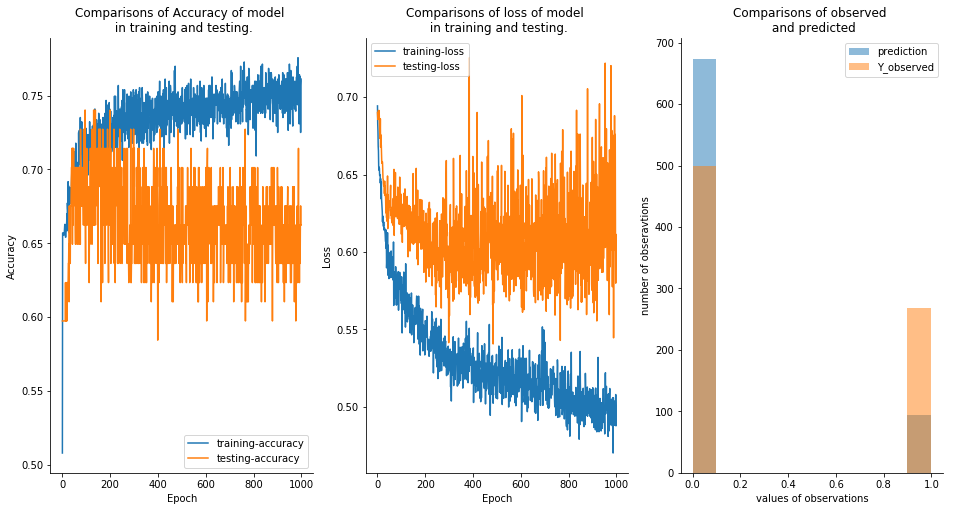

In [11]:
#neural_network(drop_out=20%, validation_split=10%)
nueral_network(0.2, 0.1)


Saved model to disk
768/768 [==============================] - 0s 38us/step

acc: 69.14%

loss: 63.39%


Confusion Matrix
True negatives:  496
False negatives:  233
False positives:  4
True positives:  35




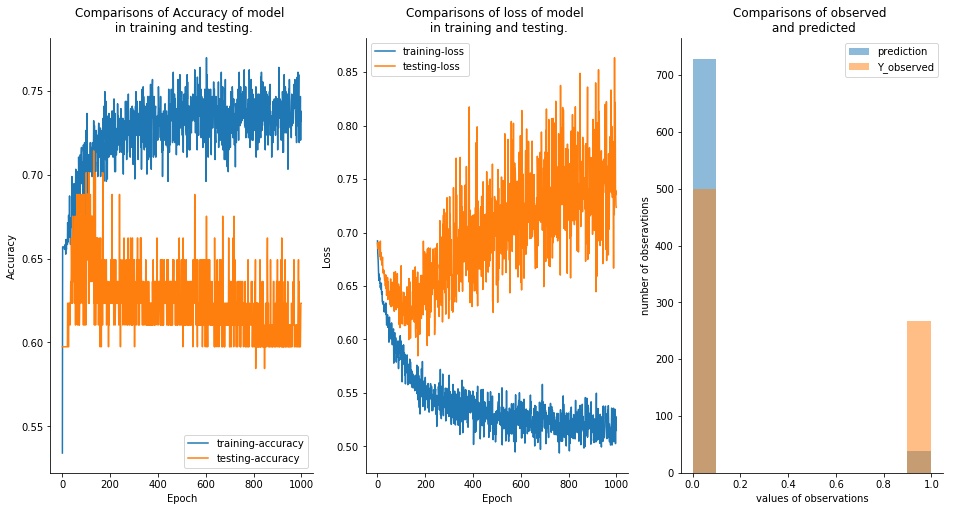

In [12]:
# neural_network(drop_out=30%, validation_split=10%)
nueral_network(0.3, 0.1)


Saved model to disk
768/768 [==============================] - 0s 45us/step

acc: 74.61%

loss: 50.26%


Confusion Matrix
True negatives:  488
False negatives:  183
False positives:  12
True positives:  85




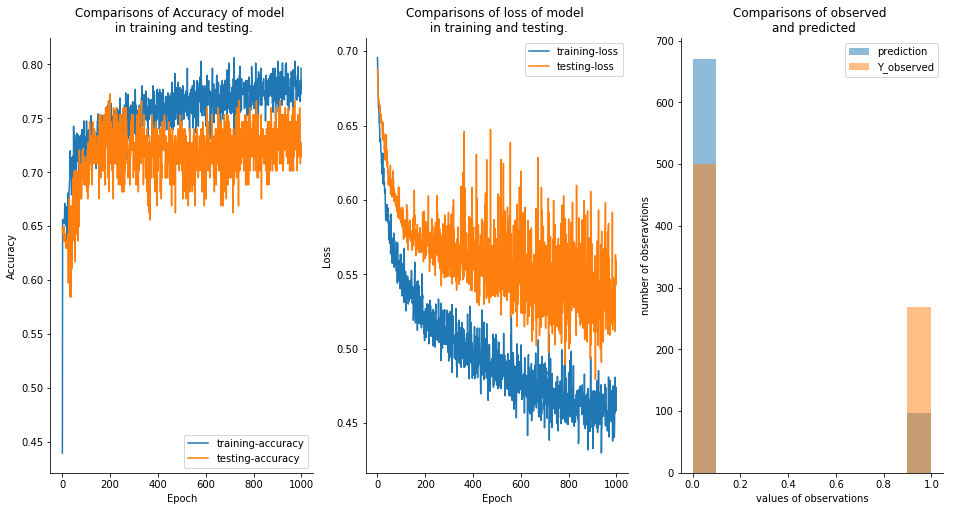

In [14]:
# neural_network(drop_out=10%, validation_split=20%)
nueral_network(0.1, 0.2)


Saved model to disk
768/768 [==============================] - 0s 48us/step

acc: 67.84%

loss: 63.91%


Confusion Matrix
True negatives:  499
False negatives:  246
False positives:  1
True positives:  22




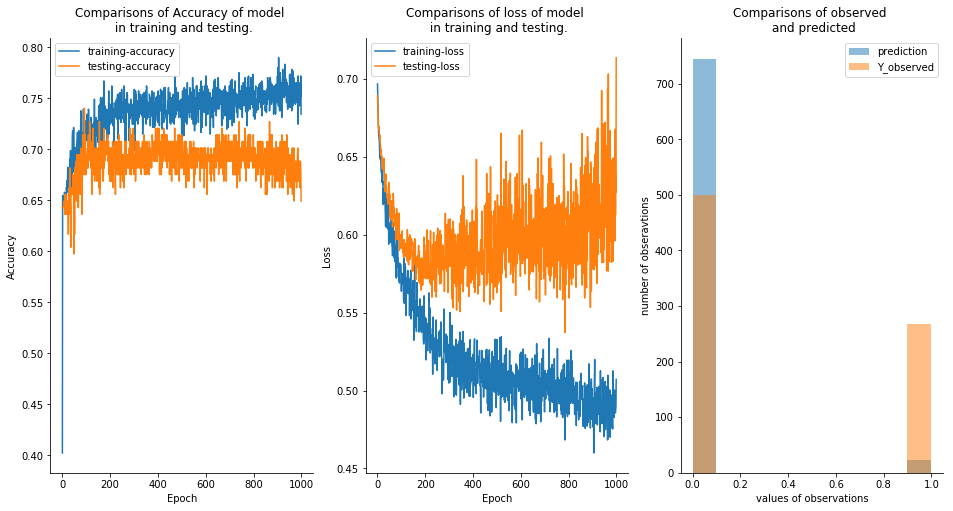

In [15]:
# neural_network(drop_out=20%, validation_split=20%)
nueral_network(0.2, 0.2)


Saved model to disk
768/768 [==============================] - 0s 42us/step

acc: 65.62%

loss: 84.93%


Confusion Matrix
True negatives:  500
False negatives:  264
False positives:  0
True positives:  4




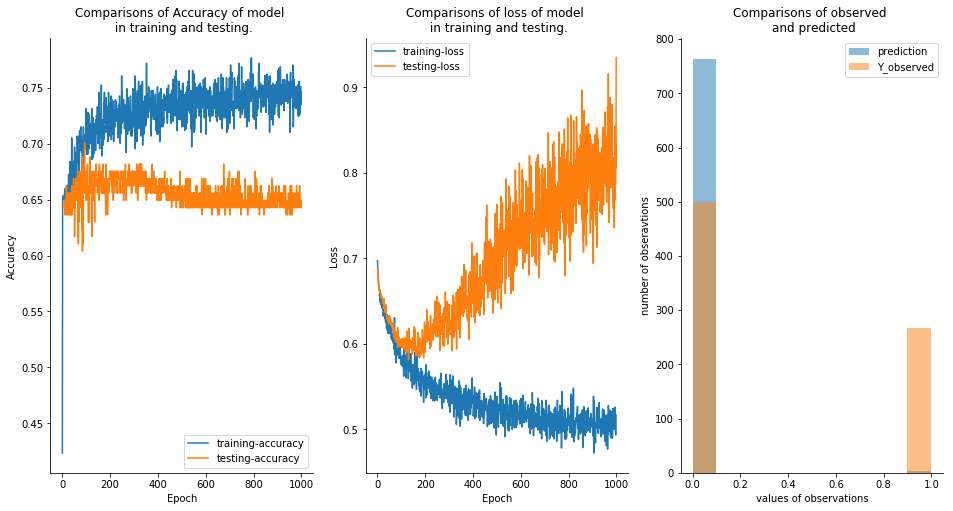

In [16]:
# neural_network(drop_out=30%, validation_split=20%)
nueral_network(0.3, 0.2)


Saved model to disk
768/768 [==============================] - 0s 67us/step

acc: 76.95%

loss: 46.81%


Confusion Matrix
True negatives:  480
False negatives:  157
False positives:  20
True positives:  111




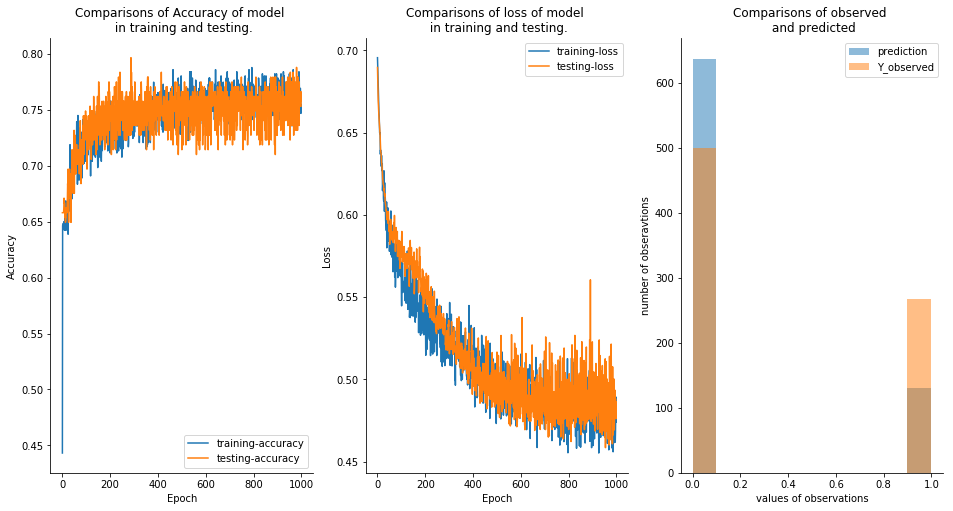

In [17]:
# neural_network(drop_out=10%, validation_split=30%)
nueral_network(0.1, 0.3)


Saved model to disk
768/768 [==============================] - 0s 50us/step

acc: 71.88%

loss: 54.30%


Confusion Matrix
True negatives:  488
False negatives:  204
False positives:  12
True positives:  64




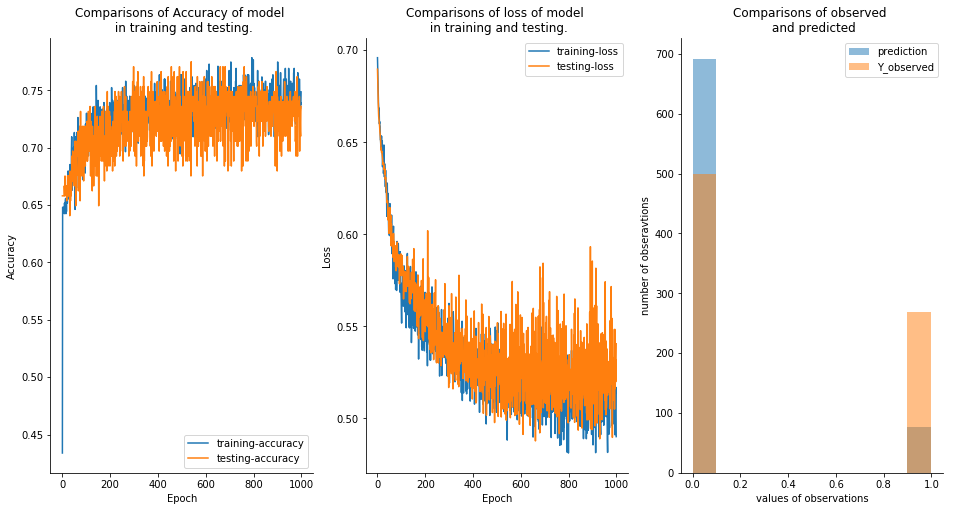

In [18]:
# neural_network(drop_out=20%, validation_split=30%)
nueral_network(0.2, 0.3)


Saved model to disk
768/768 [==============================] - 0s 52us/step

acc: 67.19%

loss: 66.20%


Confusion Matrix
True negatives:  499
False negatives:  251
False positives:  1
True positives:  17




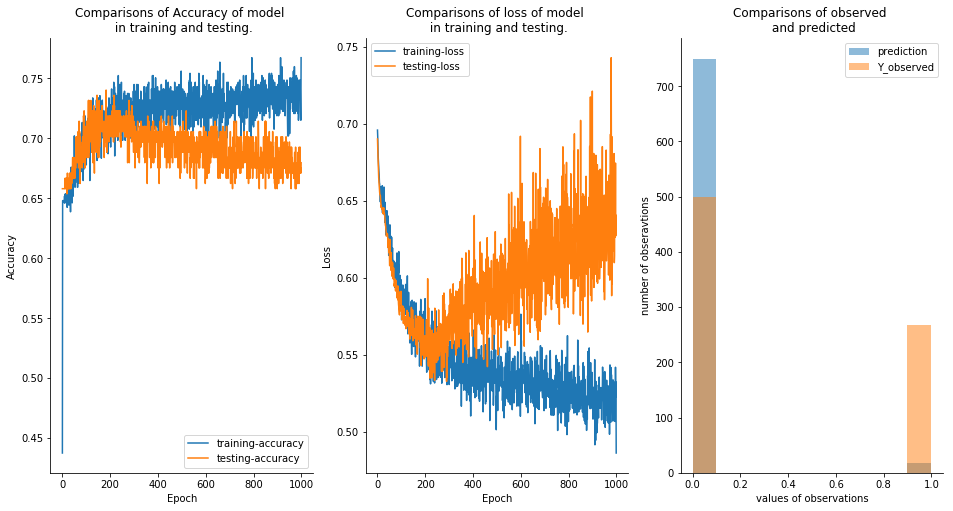

In [19]:
# neural_network(drop_out=30%, validation_split=30%)
nueral_network(0.3, 0.3)

references:

https://machinelearningmastery.com/check-point-deep-learning-models-keras/ 

https://medium.com/singlestone/keras-callbacks-monitor-and-improve-your-deep-learning-205a8a27e91c 